In [1]:
# Projection implementation of stochastic growth model adapted from Fabrice Collard's Matlab code, http://fabcol.free.fr/
# tested in Julia 1.5.0
# this code is part of chapter 5, "Advanced Numerical Techniques" from the book: "Introduction to Quantitative Macroeconomics using Julia"
# Academic Press - Elsevier
# for comments, email at: petre(dot)caraiani(at)gmail(dot)com

#packages
#Pkg.add("NLsolve");
using NLsolve;

#Pkg.add("PlotlyJS")
using PlotlyJS;

using LinearAlgebra;

# The Optimal Growth Model
# Collocation method (AR(1) case)                 
global nbk, kmin, ksup, XK, kt;
global nba, amin, asup, XA, at;
global nstate, nodea, nodek, wmat, wgrid;

# Parameters                        
nbk   = 4;   # Degree of polynomials (capital)
nba   = 2;   # Degree of polynomials (technology shock)
ncoef = (nbk+1)*(nba+1); # of coefficients
nodek = nbk+1; # of Nodes
nodea = nba+1; # of Nodes
nstate= 12;
                                                           
# Structural Parameters                    
delta  = 0.1;
beta   = 0.95;
alpha  = 0.3;
sigma  = 1.5;
ysk    =(1-beta*(1-delta))/(alpha*beta);
ksy    = 1/ysk;
ys     = ksy^(alpha/(1-alpha));
ks     = ys^(1/alpha);
is     = delta*ks;
cs     = ys-is;
ab     = 0;

# Technology shock process
rho    = 0.8;
se     = 0.2;
ma     = 0;

┌ Info: Precompiling PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1278


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17563282727295111161\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13786552744495522955\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17563282727295111161\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function hernodes(nstate)

TOL    = sqrt(2.2204e-16);
MAXIT  = 30;
PIM4   = pi^(-1/4);

n  = nstate;
m  = (n+1)/2;
m  =  convert(Int64, floor(m));
x  = zeros(n,1);
w  = zeros(n,1);

z  = 0;
z1 = 0;
pp = 0;
for i= 1:m

# Initialize the first four roots
if i == 1; 
   z= sqrt(2*n+1) - 1.85575 * (2*n+1)^(-1/6);
elseif i== 2;
   z= z - 1.14 * (n^.426)/z;
elseif i== 3;
   z= 1.86 * z - .86 * x[1];
elseif i== 4;
   z= 1.91 * z - .91 * x[2];
else;
   z= 2 * z - x[i-2];
end;

for its= 1:MAXIT
    p1 = PIM4;
    p2 = 0;
 for j  = 1:n
    p3 = p2;
    p2 = p1;
    p1 = z*sqrt(2/j)*p2 - sqrt((j-1)/j)*p3;
 end;

    pp = p2 * sqrt(2*n);
    z1 = z;
    z  = z1 - p1/pp;
if abs(z-z1) < TOL; break; end;
end;

x[i]    = z;
x[n+1-i]= -z;
w[i]= 2/(pp*pp);
w[n+1-i]= w[i];
end;       
        
return x,w
    end;

In [3]:
wgrid,wmat=hernodes(nstate);
wgrid=wgrid*sqrt(2)*se;

In [4]:
#define functions rcheb transfo itransfo
function rcheb(nn);
mod=nn-floor(nn/2)*2;
n1=floor(nn/2);
if n1==1
k=(collect(1:n1))
    elseif n1>1
k=transpose(collect(1:n1));
    end;
r1=cos.((2*k.-1)*pi/(2*nn));
r1=[r1 -r1];
if mod==1;
  r1=[r1 0];
end;
r1=vec(r1);
rr=real(sort!(r1));
return rr
end;

function transfo(x,xmin,xmax);
  z=(2*(x.-xmin)./(xmax-xmin)).-1;
return z
end;

function itransfo(x,xmin,xmax);
z=0.5*(x.+1).*(xmax.-xmin).+xmin;
return z
end;

function cheb(xx,nn);
cc=real(cos.(kron(acos.(complex(xx)),nn)))      
return cc
    end;

In [5]:
# grid for the income
amin=(ma+wgrid[nstate]);
asup=(ma+wgrid[1]);
ra=rcheb(nodea);           #roots
at=itransfo(ra,amin,asup); #grid
vnba = transpose(collect(0:nba));
#polynomials
XA=cheb(ra,vnba)

3×3 Array{Float64,2}:
 1.0  -0.866025      0.5
 1.0   6.12323e-17  -1.0
 1.0   0.866025      0.5

In [6]:
# grid for the capital stock
kmin  = log(1.2);
ksup  = log(6);
rk    = rcheb(nodek);               #roots
kt    = exp.(itransfo(rk,kmin,ksup)) #grid
vrbk = transpose(collect(0:nbk));
XK    = cheb(rk,vrbk)

5×5 Array{Float64,2}:
 1.0  -0.951057      0.809017  -0.587785      0.309017
 1.0  -0.587785     -0.309017   0.951057     -0.809017
 1.0   6.12323e-17  -1.0       -1.83697e-16   1.0
 1.0   0.587785     -0.309017  -0.951057     -0.809017
 1.0   0.951057      0.809017   0.587785      0.309017

In [7]:
#initial conditions
a0=[ -0.23759592487257;
   0.60814488103911;
   0.03677400318790;
   0.69025680170443;
  -0.21654209984197;
   0.00551243342828;
   0.03499834613714;
  -0.00341171507904;
  -0.00449139656933;
   0.00085302605779;
   0.00285737302122;
  -0.00002348542016;
  -0.00011606672164;
  -0.00003323351559;
   0.00018045618825];
param=[alpha beta delta sigma ma rho]';

In [8]:
# function makepoly
function makepoly(XA,XW);
nba   = size(XA,2);
nba1  = size(XA,1);
nbw   = size(XW,2);
nmax  = max(nba,nbw);
XX    = Float64[]  ;  
    
for i=1:nbw
   for j=1:nba     
         XX=[XX; kron(XW[:,i],XA[:,j])];
   end
end
return XX
    end;

In [9]:
f  =function(theta);
RHS=Float64[];
LHS=Float64[];
XX =Float64[];
ct = 0.0;    
c1 = 0.0;    
for i   = 1:nodek
    for j=1:nodea
        XX0  = makepoly(XA[j,:],XK[i,:]);
        ct   = exp.(dot(XX0,theta));
        XX   = [XX;XX0];
        k1   = exp.(at[j])*kt[i].^alpha+(1-delta)*kt[i]-ct;
        rk1  = transfo(log.(k1),kmin,ksup);
        #if abs(rk1)>1;disp('problème k(t+1)');end
        vrbk = transpose(collect(0:nbk));    
        xk1  = cheb(complex(rk1),vrbk);      
        a1   = rho*at[j].+(1-rho)*ma.+wgrid;
        ra1  = transfo(a1,amin,asup);           # grid
        #if abs(ra1)>1;disp('problème a(t+1)');end
        XA1  = cheb(complex(ra1),vnba);              # Polynomials
        XX1  = makepoly(XA1,xk1);
        XX1  = reshape(XX1,size(XA1,1), size(XA1,2)*size(xk1,2))    
        c1   = exp.(XX1*theta);
        aux  = transpose(wmat)*(beta*(alpha*exp.(a1)*k1.^(alpha-1).+(1-delta)).*c1.^(-sigma))/sqrt(pi);
        RHS  = [RHS;log.(aux)];
        LHS  = [LHS;log.(ct.^(-sigma))];
    end;      
end;
resid     = LHS-RHS;
return vec(resid);
end;


In [10]:
#solve the model with NLsolve
sol = nlsolve(f,a0);
println("Display final rule:",sol.zero)


Display final rule:[0.1179613804769949, 0.4938039362337588, 0.04062542074831638, 0.3618839554893491, -0.1046028802701826, -0.0019967429012142097, 0.00831575741009493, 0.0011979596674376305, -0.0009009476753789187, 3.457457243295812e-5, 0.00026351018107763455, 5.360349140119554e-5, -4.073425857857232e-6, -1.0394882239548207e-5, 3.2004536223837167e-6]


In [11]:
#final
lt  = length(sol.zero);
nk  = 20;
na  = 10;
kt  = collect(kmin:(ksup-kmin)/(nk-1):ksup);
at  = collect(amin:(asup-amin)/(na-1):asup);
rk  = transfo(kt,kmin,ksup);
rk  = vec(rk);
ra  = transfo(at,kmin,asup);
ra  = vec(ra);
vrbk= transpose(collect(0:nbk));
XT  = cheb(rk,vrbk);
vnba= transpose(collect(0:nba));
XA  = cheb(ra,vnba);
kt  = exp.(kt);
ct  = zeros(nk,na);
k1  = zeros(nk,na);
ii=[];
for i=1:nk
    for j=1:na;
    XX0  = makepoly(XA[j,:],XT[i,:]);
    ct[i,j] = exp(dot(XX0,sol.zero));
    k1[i,j] = exp(at[j])*kt[i].^alpha+(1-delta)*kt[i]-ct[i,j];
end;
end;


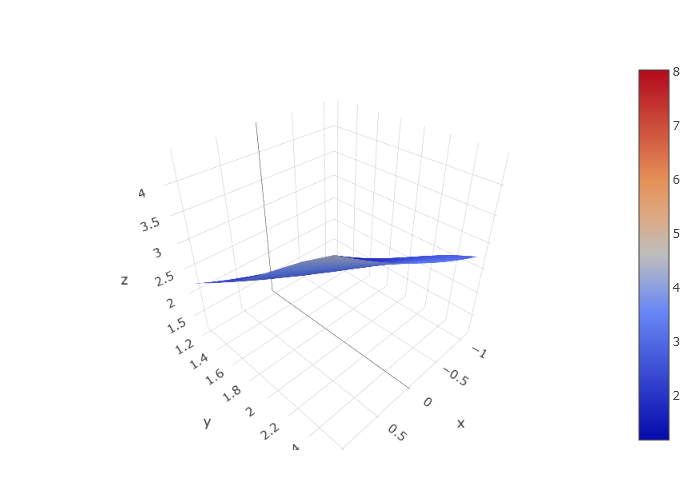

In [12]:
# using WebIO;
#if needed, run also:
#WebIO.install_jupyter_nbextension()
PlotlyJS.plot([PlotlyJS.surface(x=at,y=kt,z=k1)])